# Dcapy & Probabilistic Variables

In `Dcapy` the two main classes to define a declination model are `Arps` and `Wor`. When creating instances of any of them you can define multiple values for a single parameter to create different iterations and obverve the impact of these changes in the result forecast. 

The ability to accept multiple values opens the opportunity to evaluate uncertainty variables modeled by probabilistic distributions throughout a Montecarlo Analysis.

Let's review some cases of those instances with multiple values

In [1]:
import os
from dcapy import dca
import numpy as np 
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
a1 = dca.Arps(
    ti = 0,
    di = 0.03,
    qi = [1500,1000],
    b = 0,
    freq_di='M'
)

fr = a1.forecast(start=0,end=12,freq_input='M',freq_output='M')
print(fr)

         oil_rate        oil_cum  iteration    oil_volume
date                                                     
0     1500.000000       0.000000          0  44331.699677
1     1455.668300   44331.699677          0  43676.599812
2     1412.646800   87353.199624          0  42385.761208
3     1370.896778  129103.222093          0  41133.072650
4     1330.380655  169619.344924          0  39917.406635
5     1291.061965  208938.035362          0  38737.668979
6     1252.905317  247094.682883          0  37592.797841
7     1215.876369  284123.631045          0  36481.762759
8     1179.941792  320058.208400          0  35403.563725
9     1145.069242  354930.758495          0  34357.230289
10    1111.227331  388772.668977          0  33341.820679
11    1078.385600  421614.399852          0  32841.730875
0     1000.000000       0.000000          1  29554.466451
1      970.445534   29554.466451          1  29117.733208
2      941.764534   58235.466416          1  28257.174139
3      913.931

Here it was defined an `Arps` instance with two initial rates. The result forecast, indeed there are two different forecast, is a DataFrame with two iterations.

What if you would like to simulate a forecast with a initial rate as probabilistic variable normally distributed with a mean of 1300 and a standard deviation of 300? 

There are two ways you can do this. 

### 1- Create a probabilistic instance of `scipy.stats` module and create `n` random variables 

Random qi values generated
[1118.16369468  982.01807391 1134.72409807 1217.29411833 1666.67611805
 1028.2423041  1320.80565156 1953.59669695 1344.19507322 1455.17713872]


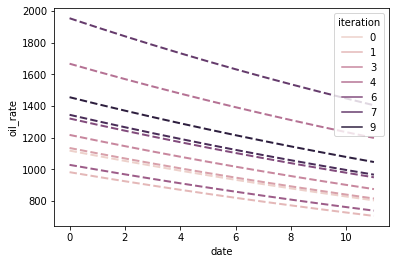

In [3]:
qi_random = stats.norm.rvs(loc=1300, scale=300, size=10, random_state=91)

print('Random qi values generated')
print(qi_random)

a2 = dca.Arps(
    ti = 0,
    di = 0.03,
    qi = qi_random.tolist(),
    b = 0,
    freq_di='M'
)

a2.plot(start=0,end=12,freq_input='M',freq_output='M')


### 2- Create a probabilistic instance of `dca.ProbVar` which is a wrapper for any of the `scipy.stats` probabilistic distributions adding some features to ease the forcasting process

In [4]:
qi_prob = dca.ProbVar(dist='norm', kw=dict(loc=1300, scale=300), seed=91)

print(qi_prob)

dist='norm' kw={'loc': 1300, 'scale': 300} factor=1.0 seed=91


+ **Get Random Samples**

In [5]:
qi_prob.get_sample(size=10)

array([1118.16369468,  982.01807391, 1134.72409807, 1217.29411833,
       1666.67611805, 1028.2423041 , 1320.80565156, 1953.59669695,
       1344.19507322, 1455.17713872])

+ **Get percent point**

In [6]:
qi_prob.get_sample(ppf=[0.1,0.5,0.9])

array([ 915.53453034, 1300.        , 1684.46546966])

+ **Use `dca.ProbVar` in `dca.Arps`

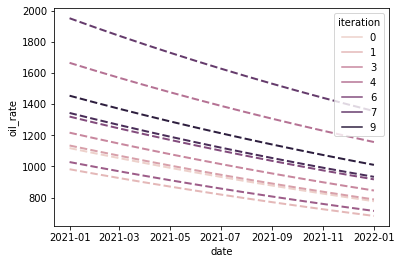

In [37]:
a3 = dca.Arps(
    ti = date(2021,1,1),
    di = 0.03,
    qi = dca.ProbVar(dist='norm', kw=dict(loc=1300, scale=300)),
    b = 0,
    freq_di='M',
    seed=91
)

a3.plot(start=date(2021,1,1),end=date(2022,1,1),freq_output='M', iter=10)

<AxesSubplot:xlabel='date', ylabel='bsw'>

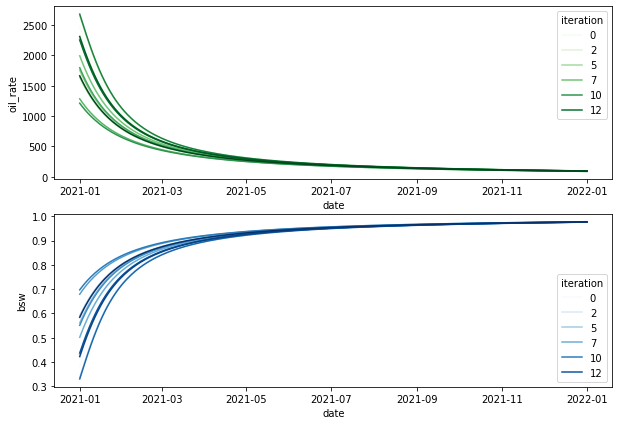

In [38]:
w1 = dca.Wor(
    bsw = dca.ProbVar(dist='uniform', kw=dict(loc=0.3, scale=0.4)),
    slope = 3e-5,
    fluid_rate = 4000,
    ti=date(2021,1,1)
)

fr = w1.forecast(start=date(2021,1,1),end=date(2022,1,1),freq_output='D', iter=15, seed=91)

fig, ax = plt.subplots(2,1, figsize=(10,7))

sns.lineplot(data=fr, x=fr.index.to_timestamp(), y='oil_rate', hue='iteration', ax=ax[0],palette='Greens')
sns.lineplot(data=fr, x=fr.index.to_timestamp(), y='bsw', hue='iteration', ax=ax[1], palette='Blues')